In [119]:
%reset -f
import psutil
print(f"Memory used: {psutil.virtual_memory().percent}%")
import gc
gc.collect()

Memory used: 7.1%


0

In [120]:
# import functions
import os
from pathlib2 import Path
from zipfile import ZipFile
import time

import pandas as pd
import numpy as np
import subprocess

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
instance_type='ml.m4.xlarge'

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import boto3
from boto3.s3.transfer import S3Transfer
import psutil
import pyarrow.parquet as pq

# Data preprocessing and visualization  


get from S3 bucket

In [121]:
# S3 configurations
bucket_name = 'pipeline2-data-storage'
prefix = 'historic-processed/df-cascade/'

# Initialize S3 client and transfer
s3 = boto3.client('s3')
transfer = S3Transfer(s3)

# List objects in the S3 directory
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
files = [obj['Key'] for obj in response.get('Contents', []) if obj['Key'].endswith('.parquet')]

# Initialize an empty list to hold each DataFrame
dataframes = []

# Loop through each file, download, and read into a DataFrame
for file_key in files:
    file_name = file_key.split('/')[-1]  # Extract the file name from the key
    print(file_name)
    # Download the file if not already downloaded
    if not os.path.isfile(file_name):
        transfer.download_file(bucket_name, file_key, file_name)
    
    # Read the Parquet file into a DataFrame and append to the list
    table = pq.read_table(file_name)
    df = table.to_pandas()
    dataframes.append(df)

# Concatenate all DataFrames into a single DataFrame
data = pd.concat(dataframes, ignore_index=True)

# Verify unique years in the 'year' column
print(data['year'].unique())

print(data.shape)

part-00000-d59ce149-c416-473f-9fae-5f3b3f930eef-c000.snappy.parquet
part-00001-d59ce149-c416-473f-9fae-5f3b3f930eef-c000.snappy.parquet
part-00002-d59ce149-c416-473f-9fae-5f3b3f930eef-c000.snappy.parquet
part-00003-d59ce149-c416-473f-9fae-5f3b3f930eef-c000.snappy.parquet
part-00004-d59ce149-c416-473f-9fae-5f3b3f930eef-c000.snappy.parquet
part-00005-d59ce149-c416-473f-9fae-5f3b3f930eef-c000.snappy.parquet
part-00006-d59ce149-c416-473f-9fae-5f3b3f930eef-c000.snappy.parquet
part-00007-d59ce149-c416-473f-9fae-5f3b3f930eef-c000.snappy.parquet
part-00008-d59ce149-c416-473f-9fae-5f3b3f930eef-c000.snappy.parquet
part-00009-d59ce149-c416-473f-9fae-5f3b3f930eef-c000.snappy.parquet
part-00010-d59ce149-c416-473f-9fae-5f3b3f930eef-c000.snappy.parquet
part-00011-d59ce149-c416-473f-9fae-5f3b3f930eef-c000.snappy.parquet
part-00012-d59ce149-c416-473f-9fae-5f3b3f930eef-c000.snappy.parquet
part-00013-d59ce149-c416-473f-9fae-5f3b3f930eef-c000.snappy.parquet
part-00014-d59ce149-c416-473f-9fae-5f3b3f930eef-

In [123]:
print(f"Memory used: {psutil.virtual_memory().percent}%")

Memory used: 50.1%


#### Data Exploration

In [124]:
# print("The #rows and #columns are ", data.shape[0] , " and ", data.shape[1])
# print("The years in this dataset are: ", list(data.year.unique()))
# print("The months covered in this dataset are: ", sorted(list(data.month.unique())))

# print("The date range for data is :" , min(data.flightdate), " to ", max(data.flightdate))

# print("The airlines covered in this dataset are: ", list(data.uniquecarrier.unique()))

# data[['origin', 'destination']] = data['route'].str.split('-', expand=True)
# print("The Origin airports covered are: ", list(data.origin.unique()))
# print("The Destination airports covered are: ", list(data.dest.unique()))
# combined_airports = list(set(data.origin.unique()).union(set(data.dest.unique())))

# Print the unique airports
# print("The unique airports covered are:", combined_airports)

# data['uniquecarrier'].unique()
data.head(10)

,deptime,uniquecarrier,flightnum,crsarrtime,depdelay,dayofmonth,tailnum,crsdeptime,arrdelay,year,...,scheduledarrhour,scheduleddephour,longhaulflight,route,flightdate,PrevDest,PrevArrDelay,IsConnected,EffectivePrevArrDelay,CumulativeDepDelay
0,2146,DL,547,2315,1,28,-N123D,2145,2,2001,...,23,21,0,ATL-LAS,2001-01-28,None,NaN,NaN,0,1
1,717,DL,352,1155,2,29,-N123D,715,5,2001,...,11,7,0,LAS-DFW,2001-01-29,LAS,2.0,1.0,2,5
2,1759,DL,301,1927,6,29,-N123D,1805,21,2001,...,19,18,0,ATL-DEN,2001-01-29,DFW,5.0,0.0,0,11
3,559,DL,1275,732,1,30,-N123D,600,3,2001,...,7,6,0,DEN-SLC,2001-01-30,DEN,21.0,1.0,21,33
4,903,DL,306,1218,18,30,-N123D,845,33,2001,...,12,8,0,SLC-DFW,2001-01-30,SLC,3.0,1.0,3,54
5,1330,DL,306,1650,5,30,-N123D,1325,10,2001,...,16,13,0,DFW-MCO,2001-01-30,DFW,33.0,1.0,33,92
6,2106,DL,659,2230,4,30,-N123D,2110,4,2001,...,22,21,0,DFW-LAX,2001-01-30,MCO,10.0,0.0,0,96
7,649,DL,1614,1150,1,31,-N123D,650,8,2001,...,11,6,0,LAX-DFW,2001-01-31,LAX,4.0,1.0,4,101
8,1310,DL,1614,1449,10,31,-N123D,1320,1,2001,...,14,13,0,DFW-MSY,2001-01-31,DFW,8.0,1.0,8,119
9,1546,DL,734,1815,4,31,-N123D,1550,7,2001,...,18,15,0,MSY-ATL,2001-01-31,MSY,1.0,1.0,1,124


 *1* means that the arrival time delayed more than 15 minutes, and *0* means all other cases.rename the column from **ArrDel15** to *is_delay*

## Processing

In [125]:
# add new column 'is_delay'. check if arrdelay is >15, if yes then 1 else 0 
data['is_delay'] = data['arrdelay'].apply(lambda x: 1 if x > 15 else 0)

### Remove null columns
# data = data[~data.is_delay.isnull()]
# data.isnull().sum(axis = 0)
data.head()

,deptime,uniquecarrier,flightnum,crsarrtime,depdelay,dayofmonth,tailnum,crsdeptime,arrdelay,year,...,scheduleddephour,longhaulflight,route,flightdate,PrevDest,PrevArrDelay,IsConnected,EffectivePrevArrDelay,CumulativeDepDelay,is_delay
0,2146,DL,547,2315,1,28,-N123D,2145,2,2001,...,21,0,ATL-LAS,2001-01-28,None,NaN,NaN,0,1,0
1,717,DL,352,1155,2,29,-N123D,715,5,2001,...,7,0,LAS-DFW,2001-01-29,LAS,2.0,1.0,2,5,0
2,1759,DL,301,1927,6,29,-N123D,1805,21,2001,...,18,0,ATL-DEN,2001-01-29,DFW,5.0,0.0,0,11,1
3,559,DL,1275,732,1,30,-N123D,600,3,2001,...,6,0,DEN-SLC,2001-01-30,DEN,21.0,1.0,21,33,0
4,903,DL,306,1218,18,30,-N123D,845,33,2001,...,8,0,SLC-DFW,2001-01-30,SLC,3.0,1.0,3,54,1


In [126]:
# Define a function to split time into hours and minutes
def split_time_column(df, column_name):
    df[f"{column_name}_hours"] = df[column_name] // 100  # Extract hours by integer division
    df[f"{column_name}_mins"] = df[column_name] % 100    # Extract minutes by modulus
    return df

# Apply the function to each column that needs splitting
columns_to_split = ['deptime', 'crsarrtime', 'crsdeptime']
for col in columns_to_split:
    data = split_time_column(data, col)

# Display the first few rows to verify
# print(data.head())
specific_columns = ['deptime', 'crsarrtime', 'crsdeptime', 'deptime_hours', 'deptime_mins',  
                    'crsarrtime_hours', 'crsarrtime_mins', 'crsdeptime_hours', 'crsdeptime_mins']
data[specific_columns].head()

,deptime,crsarrtime,crsdeptime,deptime_hours,deptime_mins,crsarrtime_hours,crsarrtime_mins,crsdeptime_hours,crsdeptime_mins
0,2146,2315,2145,21,46,23,15,21,45
1,717,1155,715,7,17,11,55,7,15
2,1759,1927,1805,17,59,19,27,18,5
3,559,732,600,5,59,7,32,6,0
4,903,1218,845,9,3,12,18,8,45


In [127]:

## model
data = data[['is_delay',
             'deptime', 'dayofmonth', 'year', 'month' ,
             'origin', 'dest', 'uniquecarrier', 'flightnum']]

categorical_columns = ['origin', 'dest', 'uniquecarrier','flightnum']


# Converting selected columns to 'category' data type
for c in categorical_columns:
    data[c] = data[c].astype('category')
data.head()

,is_delay,deptime,dayofmonth,year,month,origin,dest,uniquecarrier,flightnum
0,0,2146,28,2001,1,ATL,LAS,DL,547
1,0,717,29,2001,1,LAS,DFW,DL,352
2,1,1759,29,2001,1,ATL,DEN,DL,301
3,0,559,30,2001,1,DEN,SLC,DL,1275
4,1,903,30,2001,1,SLC,DFW,DL,306


To use one-hot encoding for the categorical columns that you selected. Then, you can concatenate those generated features to your original dataset.

In [128]:
data_dummies = pd.get_dummies(categorical_columns, drop_first=True) 
data = pd.concat([data, data_dummies], axis = 1)
data.drop(categorical_columns,axis=1, inplace=True)
data.head()

,is_delay,deptime,dayofmonth,year,month
0,0,2146,28,2001,1
1,0,717,29,2001,1
2,1,1759,29,2001,1
3,0,559,30,2001,1
4,1,903,30,2001,1


In [129]:
data.shape

(42268100, 5)

In [130]:
data.columns

Index(['is_delay', 'deptime', 'dayofmonth', 'year', 'month'], dtype='object')

In [131]:
data.head()

,is_delay,deptime,dayofmonth,year,month
0,0,2146,28,2001,1
1,0,717,29,2001,1
2,1,1759,29,2001,1
3,0,559,30,2001,1
4,1,903,30,2001,1


# Model training and evaluation

### Train-test split

In [132]:
data.rename(columns = {'is_delay':'target'}, inplace=True )

from sklearn.model_selection import train_test_split
def split_data(data):
    train, test_and_validate = train_test_split(data, test_size=0.2, random_state=42)
    test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42)

#     train, test_and_validate = train_test_split(data, test_size=0.2, random_state=42, stratify=data['target'])
#     test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['target'])
    return train, validate, test

In [133]:
from io import StringIO
# Split the data
train, validate, test = split_data(data)

# Print value counts for each target category
print(train['target'].value_counts())
print(test['target'].value_counts())
print(validate['target'].value_counts())

# Print the shapes of the datasets
print(f"Train shape: {train.shape}")
print(f"Validate shape: {validate.shape}")
print(f"Test shape: {test.shape}")

# S3 configuration
bucket = 'pipeline2-data-storage'
output_folder = 'train-validate-files/'
train_file = 'flight_train.csv'
test_file = 'flight_test.csv'
validate_file = 'flight_validate.csv'

# Create an S3 resource
s3_client = boto3.client('s3')

# Function to upload a DataFrame to S3
def upload_to_s3(df, bucket, file_name):
    # Save DataFrame to a string buffer (in CSV format)
    csv_buffer = StringIO()
    df.to_csv(csv_buffer, index=False)
    csv_buffer.seek(0)  # Move to the beginning of the buffer

    # Upload the buffer content to S3
    s3_client.put_object(Bucket=bucket, Key=os.path.join(output_folder, file_name), Body=csv_buffer.getvalue())
    print(f"File {file_name} uploaded to S3 bucket {bucket}/{output_folder}")
    
# Upload train, validate, and test datasets to S3
upload_to_s3(train, bucket, train_file)
upload_to_s3(validate, bucket, validate_file)
upload_to_s3(test, bucket, test_file)

print("Datasets uploaded successfully to S3.")

0    22199399
1    11615081
Name: target, dtype: int64
0    2776654
1    1450156
Name: target, dtype: int64
0    2772869
1    1453941
Name: target, dtype: int64
Train shape: (33814480, 5)
Validate shape: (4226810, 5)
Test shape: (4226810, 5)
File flight_train.csv uploaded to S3 bucket pipeline2-data-storage/train-validate-files/
File flight_validate.csv uploaded to S3 bucket pipeline2-data-storage/train-validate-files/
File flight_test.csv uploaded to S3 bucket pipeline2-data-storage/train-validate-files/
Datasets uploaded successfully to S3.


# Try XGBOOST

In [134]:
import sagemaker
# S3 configurations
bucket = 'pipeline2-data-storage'
prefix = 'train-validate-files'
train_file = 'flight_train.csv' # ori. csv
validate_file = 'flight_validate.csv' # ori. csv

s3_resource = boto3.Session().resource('s3')


train_channel = sagemaker.inputs.TrainingInput(
    f"s3://{bucket}/{prefix}/{train_file}",  # Correctly formatted URI
    content_type='text/csv'
)

validate_channel = sagemaker.inputs.TrainingInput(
    f"s3://{bucket}/{prefix}/{validate_file}",  # Correctly formatted URI
    content_type='text/csv'
)

# Data channels dictionary
data_channels = {
    'train': train_channel,
    'validation': validate_channel
}

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [135]:
from sagemaker.image_uris import retrieve
container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


In [136]:
sess = sagemaker.Session()
# s3_output_location="s3://{}/{}/output/".format(bucket,prefix)
s3_output_location="s3://{}/{}/".format(bucket,'xgboost-model')

xgb = sagemaker.estimator.Estimator(container,
                                    role = sagemaker.get_execution_role(), 
                                    instance_count=2, 
                                    instance_type=instance_type,
#                                     output_path=s3_output_location,
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        eval_metric = "auc", 
                        num_round=100)

xgb.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-11-10-10-54-10-421


2024-11-10 10:54:11 Starting - Starting the training job......
2024-11-10 10:54:46 Starting - Preparing the instances for training...
2024-11-10 10:55:40 Downloading - Downloading input data......
2024-11-10 10:56:21 Downloading - Downloading the training image......
2024-11-10 10:57:21 Training - Training image download completed. Training in progress.[2024-11-10 10:57:30.966 ip-10-2-144-16.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO

In [137]:
import io
def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

###### Use the batch transformer for your new model, and evaluate the model on the test dataset.

In [144]:
# bucket = 'pipeline2-data-storage'
# prefix = 'train-validate-files'

batch_X = test.iloc[:,1:];
batch_X_file='batch-in.csv' 
upload_s3_csv(batch_X_file, 'batch-in', batch_X)
batch_output = f"s3://{bucket}/train-validate-files/batch-out/"
batch_input = f"s3://{bucket}/train-validate-files/batch-in/{batch_X_file}"

In [139]:
xgb_transformer = xgb.transformer(instance_count=1,
                                       instance_type=instance_type,
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv', # ori. csv
                         split_type='Line')
xgb_transformer.wait()

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-11-10-12-08-27-823
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-11-10-12-08-28-407


...................................[2024-11-10:12:14:11:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-10:12:14:11:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-10:12:14:11:INFO] nginx config: 
worker_processes auto;
[2024-11-10:12:14:11:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-10:12:14:11:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-10:12:14:11:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header H

In [168]:
import io
# S3 configurations
# bucket = 'pipeline2-data-storage'
# prefix = 'train-validate-files/'
# train_file = 'flight_train.csv'
# validate_file = 'flight_validate.csv'

s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),',',names=['target'])


# Ensure that the data is in the correct format (if needed)
# target_predicted = target_predicted['target']  # If 'target' is a column in the JSON
test_labels = test.iloc[:,0]
print(target_predicted)

           target
0        0.344459
1        0.133877
2        0.393418
3        0.346912
4        0.543591
...           ...
4226805  0.355043
4226806  0.473336
4226807  0.375411
4226808  0.362959
4226809  0.256905

[4226810 rows x 1 columns]


In [169]:
# print(target_predicted.head())

def binary_convert(x):
    threshold = 0.55
    if x > threshold:
        return 1
    else:
        return 0

target_predicted['target'] = target_predicted['target'].apply(binary_convert)


test_labels = test.iloc[:,0]

print(target_predicted.head())

   target
0       0
1       0
2       0
3       0
4       0


In [170]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

def plot_roc(test_labels, target_predicted):
    # Ensure target_predicted is a 1D array
    if isinstance(target_predicted, pd.DataFrame):
        target_predicted = target_predicted['target'].values.flatten()  # Convert DataFrame to 1D array

    TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted).ravel()
    
    # Calculate metrics
    Sensitivity = float(TP) / (TP + FN) * 100
    Specificity = float(TN) / (TN + FP) * 100
    Precision = float(TP) / (TP + FP) * 100
    NPV = float(TN) / (TN + FN) * 100
    FPR = float(FP) / (FP + TN) * 100
    FNR = float(FN) / (TP + FN) * 100
    FDR = float(FP) / (TP + FP) * 100
    ACC = float(TP + TN) / (TP + FP + FN + TN) * 100

    # Print metrics
    print("Sensitivity or TPR: ", Sensitivity, "%") 
    print("Specificity or TNR: ", Specificity, "%") 
    print("Precision: ", Precision, "%") 
    print("Negative Predictive Value: ", NPV, "%") 
    print("False Positive Rate: ", FPR, "%")
    print("False Negative Rate: ", FNR, "%") 
    print("False Discovery Rate: ", FDR, "%" )
    print("Accuracy: ", ACC, "%") 

    # Calculate AUC
    auc_score = roc_auc_score(test_labels, target_predicted)
    print("Validation AUC:", auc_score)

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, target_predicted)
    
    # Calculate AUC for ROC curve
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    # Create the axis of thresholds (scores)
    ax2 = plt.gca().twinx()
    
    if len(thresholds) > 0 and np.all(np.isfinite(thresholds)):
        ax2.plot(fpr, thresholds, markeredgecolor='r', linestyle='dashed', color='r')
        ax2.set_ylabel('Threshold', color='r')
        ax2.set_ylim([thresholds[-1], thresholds[0]])  # Set y-limits based on thresholds
        ax2.set_xlim([fpr[0], fpr[-1]])
    else:
        print("Thresholds array is empty or contains non-finite values.")

    plt.show()  # Show the plot at the end

In [171]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_labels, target_predicted):
    matrix = confusion_matrix(test_labels, target_predicted)
    df_confusion = pd.DataFrame(matrix)
    colormap = sns.color_palette("BrBG", 10)
    sns.heatmap(df_confusion, annot=True, fmt='.2f', cbar=None, cmap=colormap)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.show()
    

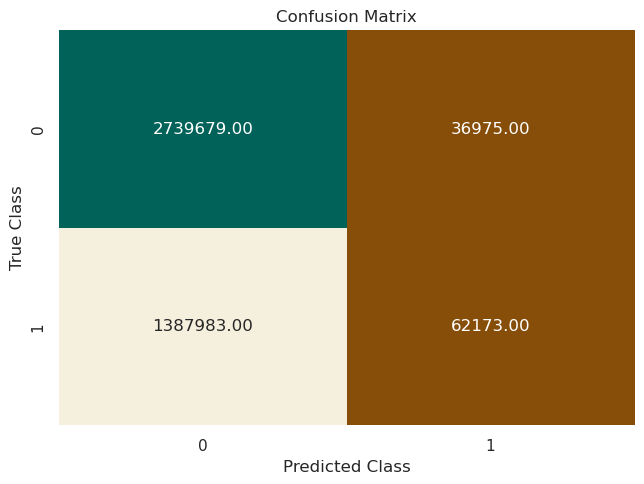

In [172]:
from sklearn.metrics import confusion_matrix
plot_confusion_matrix(test_labels , target_predicted)

Sensitivity or TPR:  4.287331845677293 %
Specificity or TNR:  98.6683612722363 %
Precision:  62.70726590551499 %
Negative Predictive Value:  66.3736274917859 %
False Positive Rate:  1.331638727763704 %
False Negative Rate:  95.71266815432271 %
False Discovery Rate:  37.29273409448501 %
Accuracy:  66.28762589281278 %
Validation AUC: 0.5147784655895679
Thresholds array is empty or contains non-finite values.


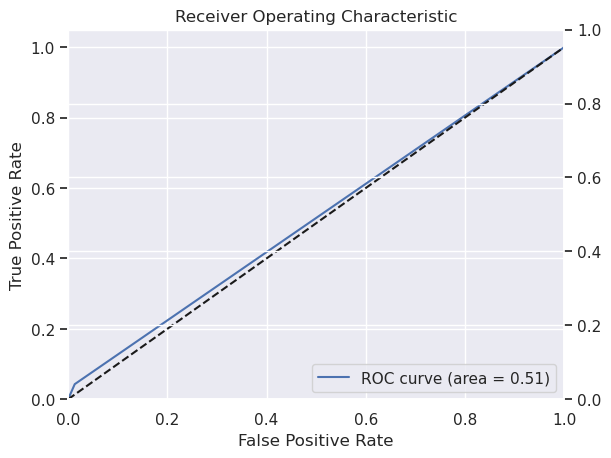

In [173]:
plot_roc(test_labels, target_predicted)

In [174]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_labels, target_predicted)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 66.29%


# Predictions for next year

In [161]:
# Generates a csv of next year with columns ["deptime", "dayofmonth", "year", "month"] in 1 hour intervals

from datetime import datetime
import pandas as pd

# Dynamically get the next year
year = datetime.now().year + 1
data = []

for month in range(1, 13):  # For each month
    days_in_month = pd.Period(f'{year}-{month:02d}').days_in_month
    for day in range(1, days_in_month + 1):  # For each day in the month
        for hour in range(24):  # Each day should have 24 rows
            deptime = hour * 100
            data.append([deptime, day, year, month])

# Create the DataFrame without column headers
flight_schedule = pd.DataFrame(data)

# Convert DataFrame to CSV in memory
csv_buffer = StringIO()
flight_schedule.to_csv(csv_buffer, index=False, header=False)

# Define S3 bucket and folder
bucket_name = "pipeline2-data-storage"
s3_key = "train-validate-files/predictions/flight_schedule_next_year.csv"

# Upload the CSV to S3
s3.put_object(
    Bucket=bucket_name,
    Key=s3_key,
    Body=csv_buffer.getvalue()
)

{'ResponseMetadata': {'RequestId': '43R6AKWA7PX5AB0A',
  'HostId': '7EqM3ocwX/4n1ZnPR8wX23gbncrl/h2qqBSrPE9obB3a3vbLDaHKSOcI5CWrX+GVVb7adqVsXgd8UEOGwolnvQ==',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '7EqM3ocwX/4n1ZnPR8wX23gbncrl/h2qqBSrPE9obB3a3vbLDaHKSOcI5CWrX+GVVb7adqVsXgd8UEOGwolnvQ==',
   'x-amz-request-id': '43R6AKWA7PX5AB0A',
   'date': 'Mon, 11 Nov 2024 04:47:13 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"f010cf67ae09492db7c3b280ce5c2023"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"f010cf67ae09492db7c3b280ce5c2023"',
 'ServerSideEncryption': 'AES256'}

In [162]:
# nextyear_input = f"s3://pipeline2-data-storage/train-validate-files/processed_nextyear_schedule.csv"
nextyear_input = f"s3://pipeline2-data-storage/train-validate-files/predictions/flight_schedule_next_year.csv"
nextyear_output = f"s3://pipeline2-data-storage/train-validate-files/predictions/"


xgb_transformer = xgb.transformer(instance_count=2,
                                       instance_type=instance_type,
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=nextyear_output)

xgb_transformer.transform(data=nextyear_input,
                         data_type='S3Prefix',
                         content_type='text/csv', # ori. csv
                         split_type='Line')
xgb_transformer.wait()

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-11-11-04-49-17-877
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-11-11-04-49-18-503


.......................................[2024-11-11:04:55:44:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-11:04:55:44:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-11:04:55:44:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2024-11-11 04:55:44 +0000] [19] [INFO] Start

In [166]:
import pandas as pd

# S3 URI for the input and output files
s3_input_uri = "s3://pipeline2-data-storage/train-validate-files/predictions/flight_schedule_next_year.csv.out"
s3_output_uri = "s3://pipeline2-data-storage/train-validate-files/predictions/nextyear_predictions.csv"

# Step 1: Read the renamed file (from S3) and the target file to which the column will be appended
probabilities_df = pd.read_csv(s3_input_uri, header=None)  # Assuming it has no header
flight_schedule_df = pd.read_csv("flight_schedule_next_year.csv", header=None)  # Local file path

# Step 2: Append the last column from the probabilities file to the flight schedule file
# Get the last column (assumed to be the prediction probabilities)
flight_schedule_df["Delay Probability"] = probabilities_df.iloc[:, -1]  # Adding as a new column named "predictions"

# Step 3: Save the combined DataFrame back to S3
flight_schedule_df.to_csv(s3_output_uri, index=False, header=False)
